# Decision Trees <a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro

Similar to SVMs, Decision Tree algorithms can handle both classification and regression problems. They are also the building block for the more powerful Random Forests alogirthm. 

1. [Training and Visualizing a Decision Tree](#visualize)
2. [Estimating Class Probabilities](#probabilities)
3. [The CART Algorithm](#cart)
4. [Regression](#regression)
5. [Instability](#instability)
6. [Exercises](#exercises)

In [2]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display, Image 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pydotplus
plt.style.use('seaborn-whitegrid')

## 1. Training and Visualizing a Decision Tree <a class="anchor" id="visualize"></a>
[[back to top]](#top)

It is easiest to understand how a Decision Tree works by visualizing the predictions made. We will use the iris dataset with only pedal length and width for classification. 

The `sklearn.tree` module includes an `export_graphviz()` method that can help visualize the classification. It saves the output as a *dot* file

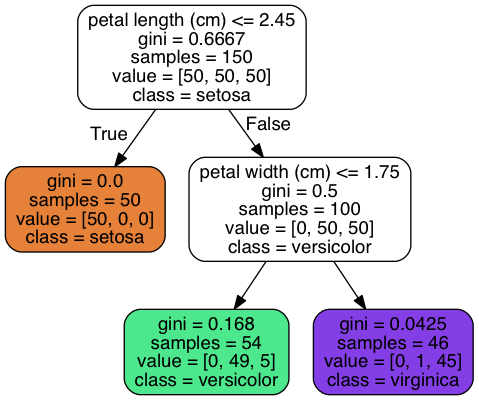

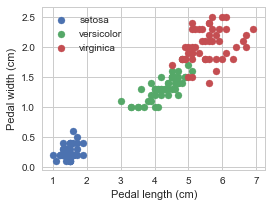

In [3]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import datasets

# Load iris dataset
iris = datasets.load_iris()
X = iris['data'][:,2:]  # pedal width + length
y = iris['target'] 

# Make quick scatter plot of training data
fig,ax=plt.subplots(1,figsize=[4,3])
for i,c in enumerate(iris.target_names):
    ax.scatter(X[:,0][y==i],X[:,1][y==i],label=c)
ax.legend();ax.set_xlabel('Pedal length (cm)');ax.set_ylabel('Pedal width (cm)')

# Train Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X,y)

# Visualize
dot_data= export_graphviz(clf,out_file=None, feature_names=iris.feature_names[2:],
               class_names=iris.target_names,rounded=True,filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

Going through the above tree, let's look at how predictions using the Decision Tree classifier will be made for a new instance:

The root node in the decision tree, depth 0, is based on the pedal width. If the width is less than or equal to 0.8 cm, then you move down to the root's left child (depth 1, left). The left child in this case is a **leaf node** (has no children) and has the predicted class - setosa. If the pedal width is greater than 0.8 cm, then you move to the right child (depth 1, right), which is not a leaf node but another node. Here the decision is if the pedal width is less than 1.75 cm. If it is then the prediction is versicolor (depth 2, left), and if not the prediction is virginica (depth 2, right). 

> An advantage of Decision Trees is that little data preperation is needed, such as feature scaling/centering. 

In the above visualization, *samples* in a node counts the number of training instances it is looking at. For example, in depth 1, right there are 100 samples that have pedal width less greater than 0.8 cm. In depth 2, right there are 46 samples with widths less than or equal to 1.75 cm. 

The *value* in a node, informs the number of training instances in each class that the node applies to. For example in depth 2, left of the 54 samples, 49 are versicolor, 6 are virginica, and 0 are setosa. 

Lastly, the *gini* attribute in a node is a measure of *impurity*. A node is considered "pure" if `gini=0` and all the training instances it applies to belong to the same class. One example is depth 1, left as it only applies to setosa. The gini score is calculated as follows:

$G_i = 1 - \sum\limits_{k=1}^{n} p_{i,k}^2$, where

* $p_{i,k}$ is the ratio of class $k$ instances among the training instances in the i<sup>th</sup> node. 

The depth 2, left node has a gini value of $1- (0/54)^2 - (49/54)^2 - (5/54)^2  = 0.168$. There are other impurity metrics that will be discussed later. 

> `sklearn` uses the Classification and Regression Tree algorithm that makes only binary decision nonleaf nodes (only 2 children per node).

Below shows the boundaries estimated by the Decision Tree classifier in the example above and shows simply what the classifier does by making sucessive splits, and creating more and more rectangles.

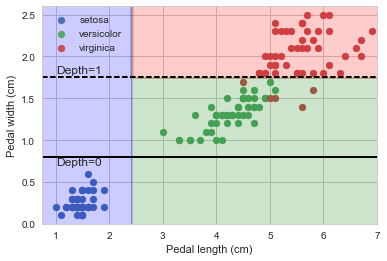

In [4]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['b','g','r'])

#  Plot decision tree boundaries
fig,ax=plt.subplots(1,figsize=[6,4])
for i,c in enumerate(iris.target_names):
    ax.scatter(X[:,0][y==i],X[:,1][y==i],label=c)
ax.legend();ax.set_xlabel('Pedal length (cm)');ax.set_ylabel('Pedal width (cm)')

x1s = np.linspace(0.75,7,100)
x2s = np.linspace(0,2.6,100)
x1,x2 = np.meshgrid(x1s,x2s)
Xnew = np.c_[x1.ravel(),x2.ravel()]
y_pred = clf.predict(Xnew).reshape(x1.shape)
ax.contourf(x1,x2,y_pred,cmap=custom_cmap,alpha=0.2)

ax.axhline(0.8,c='k',lw=2.0);ax.text(1,0.7,'Depth=0')
ax.axhline(1.75,c='k',ls='--',lw=2.0);ax.text(1,1.8,'Depth=1')

As long as the split is impure, it can be split further. However we specified a maximum depth, `max_depth=2`, though if we specified 3, then the two depth 2 nodes would add another boundary, one would likely be a boundary at pedal length around 5 to get better classification. 

The simplicity and ease of visualization is often why Decision Trees are known as *white box models*, whereas Random Forests are commonly known as *black box models*. The latter make good predictions, but it is difficult to explain why the predictions are what they are. Decision Trees are easy to interpret and can be done manually if needed. 

## 2. Estimating Class Probabilities <a class="anchor" id="probabilities"></a>
[[back to top]](#top)

Decision Trees have the ability to assign probabilities of class predictions. It does this for an instance by going through the tree to find the leaf node that predicts class *k* for the instance, and then returns the ratio of training instances of class *k* in the node. 

For example, if we have an instance with pedal length 4 cm and width 1.2 cm, the tree in the previous section will output the following probabilities based on the training instances in the node [0,49,5]:

* setosa 0%, (0/54)
* versicolor 91% (49/54)
* virginica 9% (5,54)

In [5]:
probas=clf.predict_proba(np.array([4,1.2]).reshape(1,-1))
print('Probabilties for length 4, width 1.2 :',probas)
probas=clf.predict_proba(np.array([1,0.5]).reshape(1,-1))
print('Probabilties for length 1, width 0.5 :',probas)


Probabilties for length 4, width 1.2 : [[ 0.          0.90740741  0.09259259]]
Probabilties for length 1, width 0.5 : [[ 1.  0.  0.]]


Note that the probabilities are constant within a rectangle outlined from the Decision Tree, even if an instance is close the boundary. 


## 3. The CART Algorithm <a class="anchor" id="cart"></a>
[[back to top]](#top)

As mentioned earlier, `sklearn` uses the *Classification and Regression Tree* algorithm for training (growing) Decision Trees, which grows with two splits at each node. It does this by using a single feature $k$ and a threshold $t_k$. The threshold is like we saw earlier with pedal width <= 0.8 cm. 

How are $k$ and $t_k$ determined by the algorithm? It searches for a pair ($k$,$t_k$) that makes the most pure subsets, weighted by their size. The associated cost function to minimize is:

$J(k,t_k) = \frac{m_{left}}{m} G_{left} + \frac{m_{right}}{m} G_{right} $, where

* $G_{left/right}$ is the impurity of the left/right subset
* $m_{left/right}$ is the number of instances in the left/right subset

When the training set is split, it then splits the subsets using the same algorithm, and continues recursively. It continues until it reaches the maximum depth (`max_depth` hyperparameter), or until it cannot find a split that will reduce the impurity. 

> With the CART algorithm it searches for an optimum split at the top level, and repeats on the subsets. It doesn't know whether the split will lead to the lowest impurity further down. So it is not guaranteed that the solution is optimal. An optimal solution using a tree would require $O(\exp(m))$ computational complexity.


### Computational Complexity

To make predictions using a Decision Tree, we have to traverse down from root node to leaf node. If the Decision Tree is well balanced, then this requires roughly  $O(\log_2(m))$ nodes. Because each node requires the checking the value of a single feature, the overall prediction complexity is just $O(\log_2(m))$, independent of the number of features. So predictions are fast even with large training sets.

The *training* algorithm, however, does compare all features (possibly less if `max_features` hyperparameter is set) on all samples at each node, thus the complexity is $O(n\times m\times \log(m))$. For small training sets, which `sklearn` has a few thousand instances, `sklearn` can speed up training by presorting the data (set `presort=True`), but slows down considerably for larger training sets. 

### What impurity?

We discussed the Gini impurity, but another impurity metric is Entropy. This can be done in by setting the hyperparameter `criterion='entropy'`. The concept of entropy stemmed from thermodynamics, where it can be described as the measure of disorder present in a system, which then led to the notion of entropy in information theory. In information theory, entropy can be described as the measure of the average information content in a message. A reduction of entropy is often called **information gain**. Entropy is zero when all messages are identical. 

In machine learning, entropy is used as an impurity measure; it is equal to zero when a subset contains instances of only one class. The entropy of the i<sup>th</sup> node is defined as:

$H_i = - \sum\limits_{k=1, p_{i,k}\ne 0}^{n} p_{i,k} \log(p_{i,k}) $


How does Gini and Entropy impurity differ? There usually is not a large difference between using either measure, as they lead to similar trees. Gini impurity is slightly faster computationally, though Gini tends to isolate the most frequent class in its own branch of the tree, while entropy tends to produce slightly more balanced trees. 

### Regularization Hyperparameters

Unlike other machine learning algorithms, Decision Trees make few assumptions about the underlying structure of the training data. If left unconstrained, the tree structure will adapt to fit the training data very well - most likely resulting in overfitting. It is a *nonparametric* because it does not have any parameters that are determined prior to training, so the model structure is free to fit the training data. A *parametric* model, like a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (though increasing the risk of underfitting). 

To restrict overfitting with Decision Trees, you need to restrict the training through regularization. Depending on the specific algorithm, you can usually always control the `max_depth` hyperparameter. The default is `None` which is unlimited. Reducing `max_depth` will regularize the model and reduce the risk of overfitting. The `DecisionTreeClassifier` class has a few other parameters which can be tweaked:

* `min_samples_split`: the minimum number of samples a node must have before it can be split
* `min_weight_fraction_leaf`: same as `min_samples_leaf` but expressed as a fraction of total number of weighted instances
* `max_leaf_nodes`: maximum number of leaf nodes
* `max_features`: maximum number of features that are evaluated for splitting at each node

A good rule of thumb for regularizing with all of the hyperparameters above is that increasing `min_*` or reducing `max_*` hyperparameters will regularize the model.

> Other algorithms work by training the Decision Tree with no restrictions, and then *pruning* (removing) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement is not statistically significant, using a test such as $\chi^2$. 

Let's look at an example with the moon dataset with different degrees of regularization:

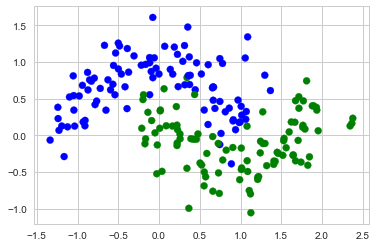

In [5]:
from sklearn.datasets import make_moons

# Load moon data
X,y = make_moons(200,noise=0.22)

# Plot data
fig,ax = plt.subplots(1,figsize=[6,4])
cmap= ListedColormap(['b','g'])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)

First we'll write a quick function that can plot the prediction contour for a classifier:

In [7]:
def plot_boundaries(clf,x1lim,x2lim, ax=None,cmap=None):
    x1s = np.linspace(x1lim[0],x1lim[1],100)
    x2s = np.linspace(x2lim[0],x2lim[1],100)
    x1,x2 = np.meshgrid(x1s,x2s)
    Xnew = np.c_[x1.ravel(),x2.ravel()]
    y_pred = clf.predict(Xnew).reshape(x1.shape)
    if ax is None:
        fig,ax = plt.subplots(1,figsize=[5,4])
    if cmap is None:
        cmap = 'jet'
    ax.contourf(x1,x2,y_pred,cmap=cmap,alpha=0.2)

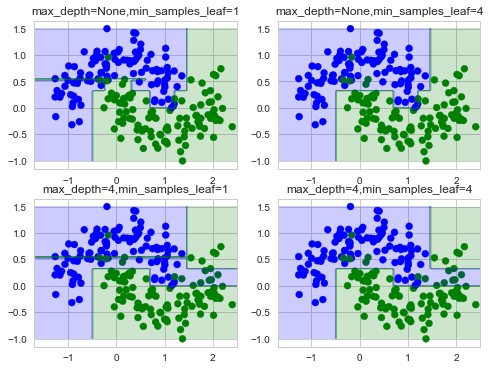

In [8]:
from sklearn.base import clone

dtree_clf = DecisionTreeClassifier()

# Hyperparameters
max_depths       = [None, 4] # max number of depths
min_samples_leafs = [1, 4]   # minimum number of samples for a leaf node

# Set up plots
fig,axes = plt.subplots(2,2,figsize=[8,6])
axes = axes.ravel()
x1lims = [-1.7,2.5];x2lims=[-1,1.5]

# Loop through parameters for training
i=0
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        clf = clone(dtree_clf)
        clf.set_params(max_depth=max_depth,min_samples_leaf=min_samples_leaf).fit(X,y)
        ### Draw boundary
        ax=axes[i]
        ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
        plot_boundaries(clf,x1lims,x2lims,ax=ax,cmap=cmap) 
        ax.set_title('max_depth={},min_samples_leaf={}'.format(max_depth,min_samples_leaf))
        i+=1

We can see above, the effects of regularizing the training for the classifier. In the top left there are no restrictions and we see that it is clearly overfitting the instances. If we regularize by restricting the number of samples at leaf nodes to 4, it becomes better (top right). We can also introduce regularization by limiting the total depths of the tree, this is done in the bottom left restricting to 4, it improves slightly. In the bottom right we specify both regularized hyperparameters, and we can see the model might now be slightly underfitting the data, not caputring the two crescent moon shapes. 

## 4. Regression <a class="anchor" id="regression"></a>
[[back to top]](#top)

Decision trees can also be used for regression, where a tree is built in the same method as classification but instead of the leaf nodes predicting a class, they predict a value.

Let's do a quick example on some noisy quadratic data:

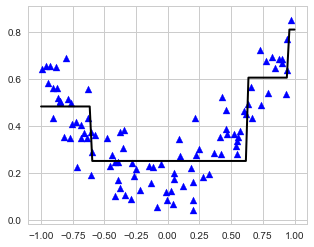

In [9]:
from sklearn.tree import DecisionTreeRegressor

# Generate quadratic data
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()
x0 = np.linspace(-1,1,100).reshape(-1,1)

# Plot data
fig,ax = plt.subplots(1,figsize=[5,4])
ax.scatter(X[:,0],y,color='b',marker='^')

# Train decision tree
reg = DecisionTreeRegressor(max_depth=2)
reg.fit(X, y)
ypred = reg.predict(x0)
ax.plot(x0,ypred,c='k',lw=2.0)

Since we specified a maximum depth of 2, there are 4 different steps in the predictions. Let's look at the visualization of the tree:

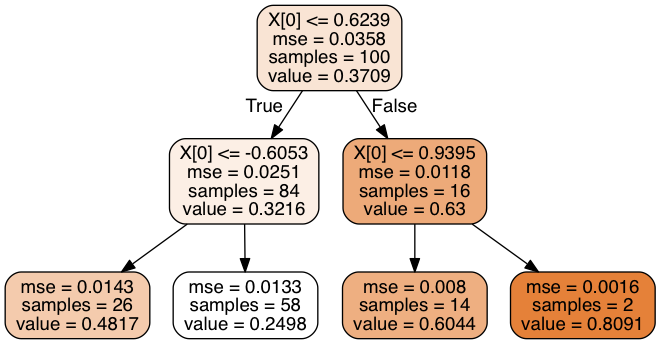

In [33]:
# Visualize
dot_data= export_graphviz(reg,out_file=None,rounded=True,filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

Suppose we wanted to make a prediction for a new instance with $x=0.75$. The root node we branch out to the right (False) since it is greater than 0.62. In the next depth 1 node, the instance takes the left (True) branch since it is less than 0.94. The assigned value is then 0.60 for the prediction. This prediction is the average value of the 14 training instances in the leaf node. The visualization above also gives the MSE of prediction for the leaf node.

For regression, the prediction for each region is always the average target value of the instances that fall in that region. We can see the effect of changing the `max_depth` below:


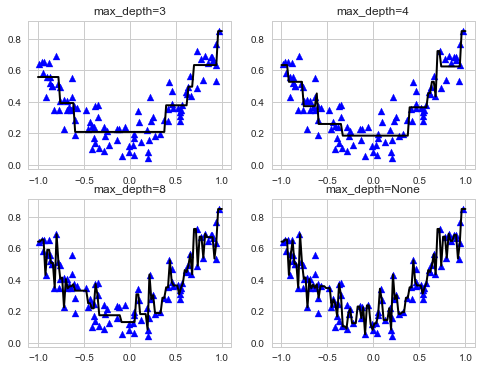

In [34]:
# Hyperparameters
max_depths       = [3,4,8,None] # max number of depths

# Set up plots
fig,axes = plt.subplots(2,2,figsize=[8,6])
axes = axes.ravel()

# Loop through parameters for training
i=0
for max_depth in max_depths:
    reg.set_params(max_depth=max_depth).fit(X,y)
    ax=axes[i]; ax.scatter(X[:,0],y,color='b',marker='^')
    ypred = reg.predict(x0)
    ax.plot(x0,ypred,c='k',lw=2.0)
    ax.set_title('max_depth={}'.format(max_depth))
    i+=1

Even a `max_depth` of 8 we can see there is overfitting, and if we do not constrain the depths at all the decision tree regressor is greatly overfitting the training data. We can repeat the above with no `max_depth` restrictions but regularize via the `min_samples_leaf`:

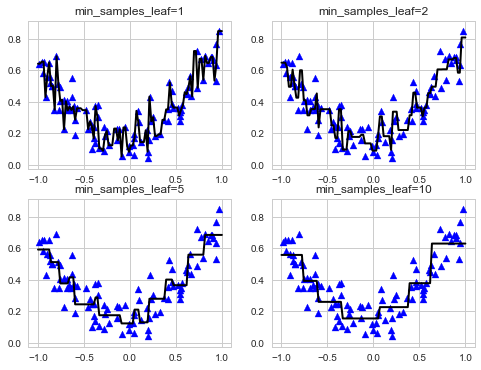

In [37]:
# Hyperparameters
min_samples_leafs = [1,2,5,10]

# Set up plots
fig,axes = plt.subplots(2,2,figsize=[8,6])
axes = axes.ravel()

# Loop through parameters for training
i=0
for min_samples_leaf in min_samples_leafs:
    reg.set_params(max_depth=None,min_samples_leaf=min_samples_leaf).fit(X,y)
    ax=axes[i]; ax.scatter(X[:,0],y,color='b',marker='^')
    ypred = reg.predict(x0)
    ax.plot(x0,ypred,c='k',lw=2.0)
    ax.set_title('min_samples_leaf={}'.format(min_samples_leaf))
    i+=1

Just like classification if we increase the `min_samples_leaf` we regularize the model. 

The CART algorithm is similar to what we had for classification, but the cost function has the MSE instead of the ratio of classes for the samples. It tries to split the training set into subsets that minimize the MSE for feature $k$ and threshold $t_k$:

$J(k,t_k) = \frac{m_{left}}{m} {MSE}_{left} + \frac{m_{right}}{m} {MSE}_{right} $, where

* ${MSE}_{left/right} = \sum\limits_{i\in node} (\hat{y_{node}} - y^{(i)})^2 $, and
* $\hat{y_{node}} = \frac{1}{m_{node}}\sum\limits_{i\in node} y^{(i)}$

To avoid overfitting, some degree of regularization is commonly needed for Decision Trees. 


## 5. Instability <a class="anchor" id="instability"></a>
[[back to top]](#top)

There are limitation using Decisions Trees for classification and regression. As we saw earlier the boundaries are orthogonal with the splits perpendicular to the feature axes. This makes the boundaries sensitive to training set rotation.

We show an example below for two datasets, one that is a rotation of another:

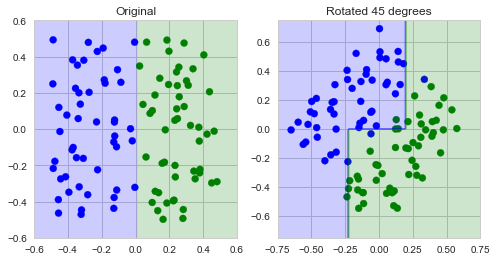

In [22]:
from scipy import ndimage
# Make data
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

# Rotate the data
angle    = 45
theta    = np.pi * angle / 180
rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
Xsrot    = np.dot(Xs,rotation)

# Classify data
clf1 = DecisionTreeClassifier(min_samples_leaf=4)
clf2 = DecisionTreeClassifier(min_samples_leaf=4)
clf1.fit(Xs,ys)
clf2.fit(Xsrot,ys)

# Plot with classifier boundaries
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[8,4])
cmap= ListedColormap(['b','g'])
ax1.scatter(Xs[:,0],Xs[:,1],c=ys, cmap=cmap)
plot_boundaries(clf1,[-0.6,0.6],[-0.6,0.6],ax=ax1,cmap=cmap) 
ax2.scatter(Xsrot[:,0],Xsrot[:,1],c=ys, cmap=cmap)
plot_boundaries(clf2,[-0.75,0.75],[-0.75,0.75],ax=ax2,cmap=cmap) 
ax1.set_title('Original');ax2.set_title('Rotated {} degrees'.format(angle))

The dataset on the right, which has been rotated, the decision boundary is not linear which we would hope for, when dealing with linearly separable data. One way to limit this is to perform principal component analysis (PCA) to prepare the data before training:

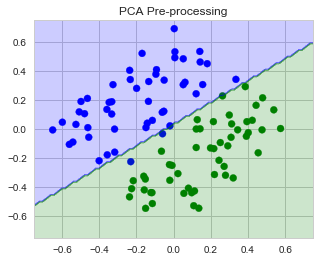

In [26]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA(n_components=2)

clf_pipe = Pipeline([('PCA', pca),
                     ('clf', clf2) 
                    ])
clf_pipe.fit(Xsrot,ys)
fig,ax1 = plt.subplots(1,1,figsize=[5,4])
ax1.scatter(Xsrot[:,0],Xsrot[:,1],c=ys, cmap=cmap)
plot_boundaries(clf_pipe,[-0.75,0.75],[-0.75,0.75],ax=ax1,cmap=cmap)
ax1.set_title('PCA Pre-processing')

We can see that PCA pre-processing helps improve the instability of Decision Trees. Another limitation with Decision Trees is that they can be sensitive to data outliers, and the training algorithm is essentially stochastic as `sklearn` selects the set of features randomly to evaluate at each node. This means you may get different decision boundaries and predictions from models on the same training data unless `random_state` hyperparameter is specified.



## 6.  Exercises <a class="anchor" id="exercises"></a>
[[back to top]](#top)

> **1.**  What is the approximate depth of a Decision Tree trained (without restrictions on a training set with 1 million instances?

If we assume that the Decision Tree is well balanced, then this requires roughly  $O(\log_2(m))$ nodes. Which is around a depth of 20. 

> **2.** Is a node's Gini impurity generally lower or greater than its parent's? Is it generally lower/greater, or *always* lower/greater?

The Gini impurity is generally lower in a child node than the parent's as the algorithm seeks to minimize the child node's impurity until it cannot be split anymore. Though since there are 2 children nodes, it is possible that one may be larger than the parent's, but weighted average of the two is smaller than the parent's.

> **3.** If a Decision Tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?

As we found, decreasing the depth of a Decision Tree helps regularize the model. So decreasing the `max_depth` hyperaparameter is one method to prevent overfitting.

> **4.** If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?

Scaling of training data is not necessary for Decision Trees, so doing so would not help with the underfitting. Rather, data rotation through PCA would be a better pre-processing technique. 

> **5.** If it takes one hour to train a Decision Tree on a training set of 1 million instances, roughly how much time will it take to train another Decision Tree on a training set of 10 million instances?

The training algorithm has a computational complexity of order, $O(n\times m\times \log(m))$, so if we assume that between the two cases above the number of features are the same then we can find that time for 10 million instances is equal to:

$ \frac{1h}{10^{6} \log_2{10^6}} 10^{7} \log_2{10^7} = 11.7 h$

The Dual form is faster to solve than the primal when the number of training instances is smaller than the number of features. So for the question above, if speed is priority then the primal form would be faster. But the dual form allows the kernel trick to be applied so the extra computational time might be worth it.

> **6.** If your training set contains 100,000 instances, will setting `presort=True` help speed up training?

No, presorting only helps improve speed for instances less than a few thousand. Above it makes it slower.


> **7.** Train and fine-tune a Decision Tree for the moons dataset:
1. Generate a moons dataset with 10,000 samples and noise of 0.4
2. Split into a training set and test set
3. Use grid search to find good hyperparameters for `DecisionTreeClassifier`
4. Train it on the full training set using these hyperparameters, and then measure the performance on the test set. You should get an accuracy of 85-87%.

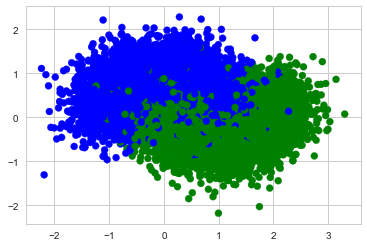

In [43]:
from sklearn.datasets import make_moons

### 7.1 Make moons dataset
X,y = make_moons(10000,noise=0.4)

# Plot data
fig,ax = plt.subplots(1,figsize=[6,4])
cmap= ListedColormap(['b','g'])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)

In [44]:
### 7.2 split into train and test sets
from sklearn.model_selection import train_test_split

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)

#### 7.3 Use grid search to find opitmal hyperparameters for DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Report for grid search
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  (results['mean_test_score'][candidate]),
                  (results['std_test_score'][candidate])  ))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

tree_clf   = DecisionTreeClassifier()
param_grid = [ {# 'max_depth':[None,10,9,8,7],
                # 'min_samples_leaf':[30,40,50,60],
                 'min_samples_split':[2,3,4],
                 'max_leaf_nodes':[10,20,40]
              }]
# Grid search
GS_tree = GridSearchCV(tree_clf,param_grid,cv=5,scoring='accuracy',n_jobs=-1)
GS_tree.fit(Xtrain,ytrain)

#Print scores
results = GS_tree.cv_results_
report(results)

Model with rank: 1
Mean validation score: 0.866 (std: 0.010)
Parameters: {'max_leaf_nodes': 20, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.866 (std: 0.010)
Parameters: {'max_leaf_nodes': 20, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.866 (std: 0.010)
Parameters: {'max_leaf_nodes': 20, 'min_samples_split': 4}



`GridSearchCV` automatically trains the best estimator on the whole training set, so it is not needed to do this and we can then look at the accuracy on the test set:

In [45]:
### 7.4 Evaluate on test data
from sklearn.metrics import accuracy_score

ypred = GS_tree.predict(Xtest)
print('Accuracy of test set :',accuracy_score(ytest,ypred))

Accuracy of test set : 0.874


We were able to get an accuracy of around 85% with the noisy moon dataset.

> **8.** Grow a forest of Decision Trees:
1. Continue the previous exercise and generate 1,000 subsets of the training set, each containing 100 instances selected randomly using `ShuffleSplit`
2. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 trees on the test set. Since they are trained on smaller sets, the trees will likely perform worse than the first Decision Tree.
3. Now for each test set instance, generate the predictions of the 1,000 trees, and keep only the most frequent prediction to get a majority-vote.
4. Evaluate these predictions on the test set, and you should obtain a higher accuracy by about 0.5-1.5%.

In [46]:
### 8.1
from sklearn.model_selection import ShuffleSplit

n_trees    = 1000
n_instances= 100

subsets = []
rs = ShuffleSplit(n_splits=n_trees, test_size=len(Xtrain) - n_instances)

for train_index, test_index in rs.split(Xtrain):
    Xsubtrain = Xtrain[train_index]
    ysubtrain = ytrain[train_index]
    subsets.append((Xsubtrain,ysubtrain))

### 8.2 
from sklearn.base import clone

# Create forest of decision trees
forest = [clone(GS_tree.best_estimator_) for _ in range(n_trees)]
scores = []
for tree, (Xsubtrain,ysubtrain) in zip(forest,subsets):
    tree.fit(Xsubtrain,ysubtrain)
    ypred = tree.predict(Xtest)
    scores.append(accuracy_score(ytest,ypred) )

print('Mean of all {} trees on test set: {}'.format(n_trees,np.mean(scores)))
    

Mean of all 1000 trees on test set: 0.79975


In [47]:
### 8.3 
from scipy.stats import mode

ypreds_all = [] 
# Save all the predictions instead of taking mean of resulting scores
for i,tree in enumerate(forest):
    ypred = tree.predict(Xtest)
    ypreds_all.append(ypred)
ypreds_all = np.array(ypreds_all)

# For each test instance, take a majority vote
yvote,counts = mode(ypreds_all,axis=0)

print('Majority vote of all {} trees accuracy score on test set: {}'.format(n_trees,accuracy_score(ytest,yvote.squeeze())))


Majority vote of all 1000 trees accuracy score on test set: 0.8725


We see an increase in the accuracy using the forest of 1,000 trees compared to a single Decision Tree.

## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).